In [1]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools
import pandas as pd
import numpy as np
# import supervision as sv
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

# from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
import matplotlib.pyplot as plt

/tmp/ipykernel_35530/3130872162.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'maximum_weight_recommendation': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'}
}

allowed_units = {unit for entity in entity_unit_map for unit in entity_unit_map[entity]}

In [3]:
CHECKPOINT = "microsoft/Florence-2-large"
model_name = "deepset/roberta-base-squad2"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

vlm_model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
vlm_processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

text_model = AutoModelForQuestionAnswering.from_pretrained(model_name)
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

/home/vishwa/Enter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [5]:
image = Image.open('/home/vishwa/amzn-ml/student_resource 3/images/41-NCxNuBxL.jpg')
task = "<MORE_DETAILED_CAPTION>"
text = "<MORE_DETAILED_CAPTION>"

inputs = vlm_processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = vlm_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = vlm_processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
parsed_answer = vlm_processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
# print(parsed_answer)

In [6]:
entity_name = 'width'
QA_input = {
    'question': f"What is the value of {entity_name}",
    'context': f"{parsed_answer['<MORE_DETAILED_CAPTION>']}"
}

res = nlp(QA_input)
print(res)

{'score': 0.7092161178588867, 'start': 278, 'end': 282, 'answer': '15cm'}


# Testing it on train_set - 50 images

In [7]:
train_df = pd.read_csv('student_resource 3/dataset/train.csv')

In [8]:
train_df['image_link'] = train_df['image_link'].str.split('/').str[-1]

In [9]:
train_df = train_df[:5]

In [10]:
train_df

,image_link,group_id,entity_name,entity_value
0,61I9XdN6OFL.jpg,748919,item_weight,500.0 gram
1,71gSRbyXmoL.jpg,916768,item_volume,1.0 cup
2,61BZ4zrjZXL.jpg,459516,item_weight,0.709 gram
3,612mrlqiI4L.jpg,459516,item_weight,0.709 gram
4,617Tl40LOXL.jpg,731432,item_weight,1400 milligram


  0%|          | 0/5 [00:00<?, ?it/s]

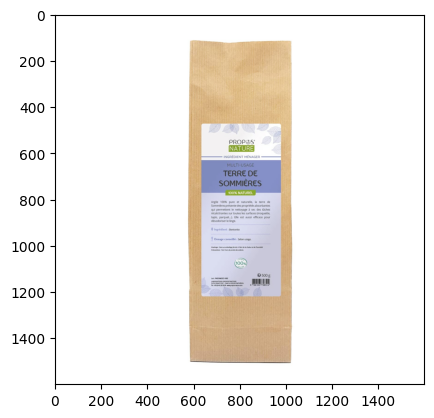

item_weight
{'quad_boxes': [[751.2000122070312, 541.6000366210938, 866.4000244140625, 541.6000366210938, 866.4000244140625, 565.6000366210938, 751.2000122070312, 565.6000366210938], [752.7999877929688, 568.7999877929688, 863.2000122070312, 568.7999877929688, 863.2000122070312, 594.4000244140625, 752.7999877929688, 594.4000244140625], [727.2000122070312, 610.4000244140625, 892.0, 610.4000244140625, 892.0, 626.4000244140625, 727.2000122070312, 626.4000244140625], [746.4000244140625, 645.6000366210938, 863.2000122070312, 645.6000366210938, 863.2000122070312, 663.2000122070312, 746.4000244140625, 663.2000122070312], [725.6000366210938, 674.4000244140625, 880.7999877929688, 674.4000244140625, 880.7999877929688, 704.7999877929688, 725.6000366210938, 704.7999877929688], [706.4000244140625, 717.6000366210938, 896.7999877929688, 717.6000366210938, 896.7999877929688, 749.6000366210938, 706.4000244140625, 749.6000366210938], [748.0, 767.2000122070312, 860.0, 767.2000122070312, 860.0, 783.20001220

 20%|██        | 1/5 [01:41<06:45, 101.33s/it]

{'score': 0.003793651470914483, 'start': 543, 'end': 565, 'answer': "500 g', '2 707813 7084"}
Expected answer:  500.0 gram


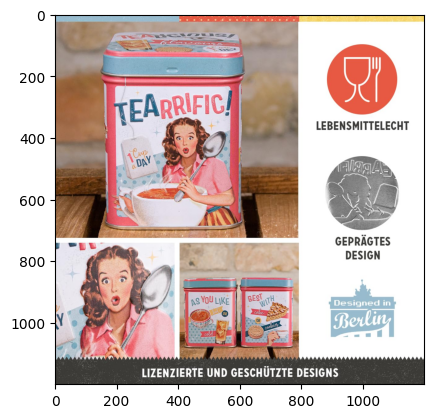

 40%|████      | 2/5 [02:02<02:43, 54.34s/it] 

item_volume
{'quad_boxes': [[187.8000030517578, 273.0, 568.2000122070312, 244.20001220703125, 575.4000244140625, 333.0, 195.00001525878906, 366.6000061035156], [843.0000610351562, 343.8000183105469, 1150.2000732421875, 343.8000183105469, 1150.2000732421875, 379.8000183105469, 843.0000610351562, 379.8000183105469], [228.60000610351562, 454.20001220703125, 295.8000183105469, 425.4000244140625, 306.6000061035156, 454.20001220703125, 239.40000915527344, 484.20001220703125], [244.20001220703125, 479.4000244140625, 306.6000061035156, 454.20001220703125, 316.20001220703125, 483.0000305175781, 252.60000610351562, 508.20001220703125], [906.6000366210938, 715.800048828125, 1090.2000732421875, 715.800048828125, 1090.2000732421875, 753.0, 906.6000366210938, 753.0], [939.0000610351562, 763.800048828125, 1056.60009765625, 763.800048828125, 1056.60009765625, 797.4000244140625, 939.0000610351562, 797.4000244140625], [437.4000244140625, 913.800048828125, 567.0, 911.4000244140625, 568.2000122070312, 945

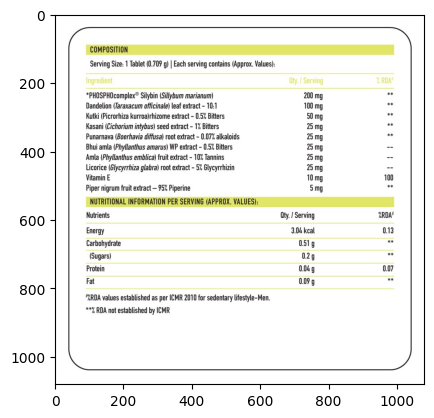

 40%|████      | 2/5 [06:57<10:26, 208.97s/it]


KeyboardInterrupt: 

In [11]:
task = "<OCR_WITH_REGION>"
text = "<OCR_WITH_REGION>"
vlm_model.eval()
text_model.eval()

for i in tqdm(range(len(train_df))):
    image = Image.open('/home/vishwa/amzn-ml/student_resource 3/train_images/' + train_df['image_link'][i])
    plt.imshow(image)
    plt.show()
    inputs = vlm_processor(text=text, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = vlm_model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = vlm_processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = vlm_processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
    print(train_df['entity_name'][i])
    print(parsed_answer['<OCR_WITH_REGION>'])
    QA_input = {
        'question': f"What is the value of {train_df['entity_name'][i]}",
        'context': f"{parsed_answer['<OCR_WITH_REGION>']['labels']}"
    }
    res = nlp(QA_input)
    print(res)
    print('Expected answer: ', train_df['entity_value'][i])